In [1]:
import json

with open('proj4_params.json', 'r') as f:
    params = json.load(f)

params

{'city': 'Cracow', 'id_column': 'lamp_id'}

In [2]:
import geopandas as gpd
df = gpd.read_file('proj4_points.geojson')
df.to_crs('epsg:4326', inplace=True)
df.head()

/Users/eryk/miniconda3/envs/ml/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/p3/1mlnmr7563b2lsdz5xhg4k7w0000gn/T/ipykernel_37019/1369719866.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (ht

,lamp_id,circuit,label,geometry
0,5907,4260,4260 III/9,POINT (19.89914 50.07404)
1,5908,4104,4104 I/7,POINT (19.89139 50.07505)
2,5909,4070,4070 I/8,POINT (19.89821 50.07306)
3,5910,4148,4148 I/14,POINT (19.88872 50.07352)
4,5911,4148,4148 I/4,POINT (19.89168 50.07328)


In [3]:
lamps_counted = {}
gdf_meters = df.to_crs('epsg:2180')
for _, row in gdf_meters.iterrows():
    buffer = row['geometry'].buffer(100)
    lamps_counted[row['lamp_id']] = gdf_meters['geometry'].within(buffer).sum()


In [4]:
import pandas as pd
lamps_counted_df = pd.DataFrame.from_dict(lamps_counted, orient='index', columns=['count'])
lamps_counted_df.to_csv('proj4_ex01_counts.csv', index_label=params['id_column'])

In [5]:
lamps_coords = {}
for i, row in df.iterrows():
    lamps_coords[row['lamp_id']] = (row['geometry'].y, row['geometry'].x)
lamps_coords_df = pd.DataFrame.from_dict(lamps_coords, orient='index', columns=['lat', 'lon'])
lamps_coords_df.to_csv('proj4_ex01_coords.csv', index_label=params['id_column'])

In [6]:
import pyrosm
fp = pyrosm.get_data(params['city'])
osm = pyrosm.OSM(fp)
gdf_driving = osm.get_network(network_type="driving")
gdf_driving.to_crs('epsg:3857', inplace=True)

In [7]:
gdf_driving = gdf_driving[gdf_driving['highway'] == 'primary']
gdf_driving = gdf_driving[['id', 'name', 'geometry']]
gdf_driving.rename(columns={'id': 'osm_id'}, inplace=True)
gdf_driving

,osm_id,name,geometry
13,4908479,Aleja generała Władysława Andersa,"MULTILINESTRING ((2228593.541 6460920.551, 222..."
16,5095909,Zakopiańska,"MULTILINESTRING ((2217145.946 6444891.138, 221..."
19,5095973,Marii Konopnickiej,"MULTILINESTRING ((2218837.289 6454841.639, 221..."
21,5095979,Tadeusza Ptaszyckiego,"MULTILINESTRING ((2233855.201 6458067.571, 223..."
22,6227984,Jasnogórska,"MULTILINESTRING ((2214351.949 6462906.404, 221..."
...,...,...,...
61284,1156788935,Tadeusza Ptaszyckiego,"MULTILINESTRING ((2233104.452 6457959.197, 223..."
61341,1158966764,Częstochowska,"MULTILINESTRING ((2211462.696 6469667.201, 221..."
61804,1163122485,None,"MULTILINESTRING ((2222347.148 6463950.593, 222..."
61805,1163122487,None,"MULTILINESTRING ((2222353.828 6463979.247, 222..."


In [8]:
gdf_driving.to_file('proj4_ex02_primary_roads.geojson', driver='GeoJSON')

In [9]:
gdf_driving.to_crs('epsg:2178', inplace=True)
gdf_driving['buffer'] = gdf_driving['geometry'].buffer(50)
gdf_driving.dropna(inplace=True)
gdf_driving.head()

,osm_id,name,geometry,buffer
13,4908479,Aleja generała Władysława Andersa,"MULTILINESTRING ((7429852.801 5550277.502, 742...","POLYGON ((7429861.359 5550221.107, 7429835.584..."
16,5095909,Zakopiańska,"MULTILINESTRING ((7422344.594 5540093.243, 742...","POLYGON ((7422340.140 5539927.042, 7422338.314..."
19,5095973,Marii Konopnickiej,"MULTILINESTRING ((7423525.207 5546465.026, 742...","POLYGON ((7423416.307 5546565.101, 7423414.356..."
21,5095979,Tadeusza Ptaszyckiego,"MULTILINESTRING ((7433212.463 5548404.882, 743...","POLYGON ((7433113.663 5548454.987, 7433113.738..."
22,6227984,Jasnogórska,"MULTILINESTRING ((7420716.391 5551678.418, 742...","POLYGON ((7420638.962 5551743.772, 7420637.490..."


In [10]:
roads_lamps = {}

for _, row in gdf_driving.iterrows():
    if row['name'] in roads_lamps:
        roads_lamps[row['name']] += gdf_meters['geometry'].within(row['buffer']).sum()
    else:
        roads_lamps[row['name']] = gdf_meters['geometry'].within(row['buffer']).sum()


In [11]:
roads_lamps_df = pd.DataFrame.from_dict(roads_lamps, orient='index', columns=['point_count'])
roads_lamps_df.to_csv('proj4_ex03_streets_points.csv', index_label='name')

In [12]:
countries_gdf = gpd.read_file('proj4_countries.geojson')
countries_gdf.to_crs('epsg:3857', inplace=True)
countries_gdf.head()

,name,geometry
0,Vietnam,"MULTIPOLYGON (((11584347.576 1163093.973, 1158..."
1,Sweden,"MULTIPOLYGON (((2123582.353 7932931.805, 21143..."
2,Poland,"POLYGON ((2627727.019 6713424.195, 2633695.222..."
3,Italy,"MULTIPOLYGON (((781584.581 5768463.580, 785443..."
4,Chile,"MULTIPOLYGON (((-12164991.780 -3141027.565, -1..."


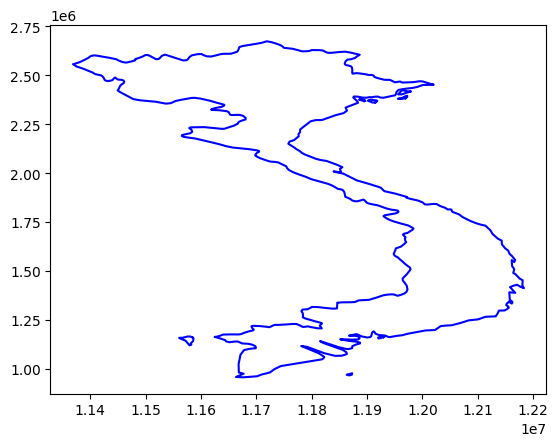

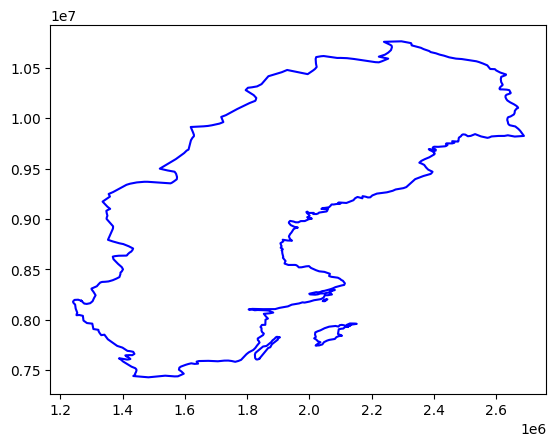

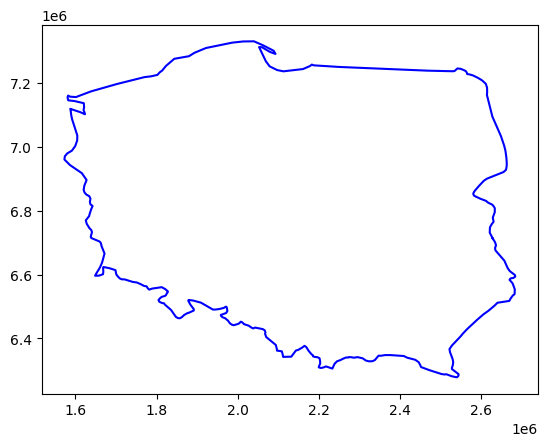

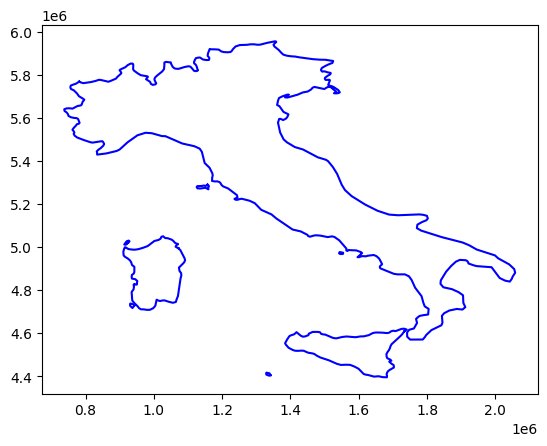

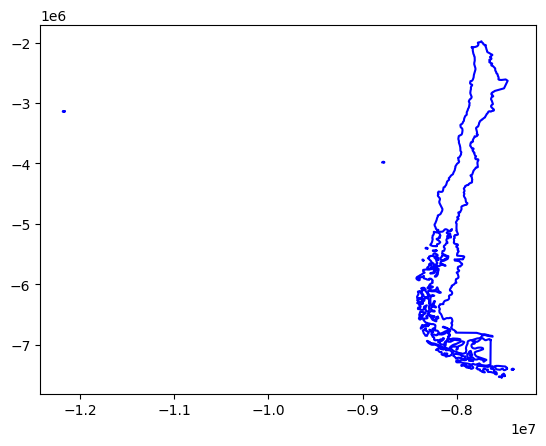

In [13]:
import matplotlib.pyplot as plt

for _, row in countries_gdf.iterrows():
    fig1, ax1 = plt.subplots()
    if row['geometry'].geom_type == 'Polygon':
        x,y = row['geometry'].exterior.xy
        ax1.plot(x, y, color='blue')
    else:
        for polygon in row['geometry'].geoms:
            ax1.plot(*polygon.exterior.xy, color='blue')

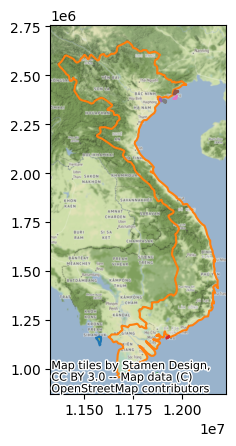

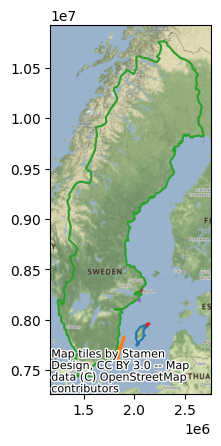

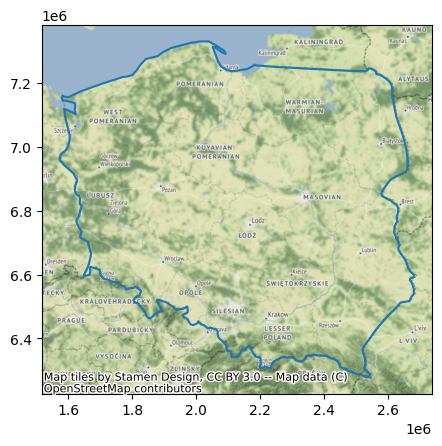

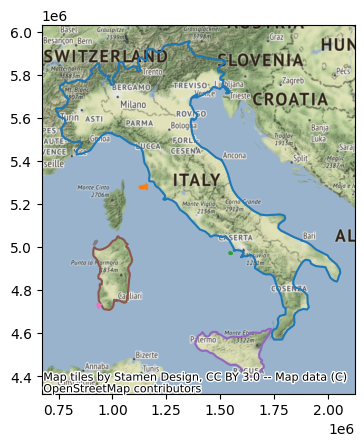

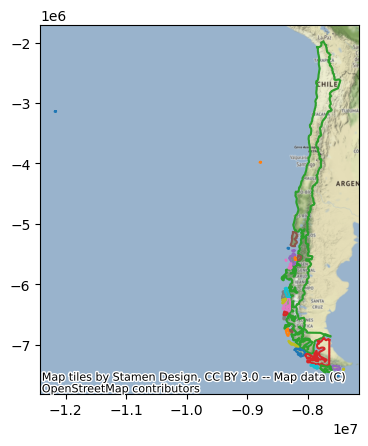

In [14]:
import contextily as cx

for _, row in countries_gdf.iterrows():
    fig1, ax1 = plt.subplots()
    if row['geometry'].geom_type == 'Polygon':
        x,y = row['geometry'].exterior.xy
        ax1.plot(x, y)
        cx.add_basemap(ax1)
    else:
        for polygon in row['geometry'].geoms:
            ax1.plot(*polygon.exterior.xy)
        cx.add_basemap(ax1)
    plt.savefig(f'proj4_ex04_{row["name"].lower()}.png', bbox_inches='tight')

In [15]:
countries_gdf_copy = countries_gdf.copy()
countries_gdf_copy['geometry'] = countries_gdf['geometry'].boundary
countries_gdf_copy.head()

,name,geometry
0,Vietnam,"MULTILINESTRING ((11584347.576 1163093.973, 11..."
1,Sweden,"MULTILINESTRING ((2123582.353 7932931.805, 211..."
2,Poland,"LINESTRING (2627727.019 6713424.195, 2633695.2..."
3,Italy,"MULTILINESTRING ((781584.581 5768463.580, 7854..."
4,Chile,"MULTILINESTRING ((-12164991.780 -3141027.565, ..."


In [16]:
import pickle
with open('proj4_ex04_gdf.pkl', 'wb') as f:
    pickle.dump(countries_gdf_copy, f)